# Information Entropy as uncertainty metrics

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [2]:
# Step 4: Calculate the entropy on a discrete probability distribution
def entropy(probs):
    entropy = -torch.sum(probs * torch.log2(probs + 1e-10), dim=1)
    return entropy

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [4]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

In [5]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [6]:

# Step 1: Load the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [7]:
# Step 1: Load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Cifar10CnnModel().to(device)
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


# Train

In [9]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, trainloader, testloader, opt_func)

Epoch [0], train_loss: 1.7436, val_loss: 1.3841, val_acc: 0.4795
Epoch [1], train_loss: 1.1626, val_loss: 1.0159, val_acc: 0.6383
Epoch [2], train_loss: 0.8860, val_loss: 0.9189, val_acc: 0.6868
Epoch [3], train_loss: 0.7076, val_loss: 0.7702, val_acc: 0.7404
Epoch [4], train_loss: 0.5721, val_loss: 0.7427, val_acc: 0.7490


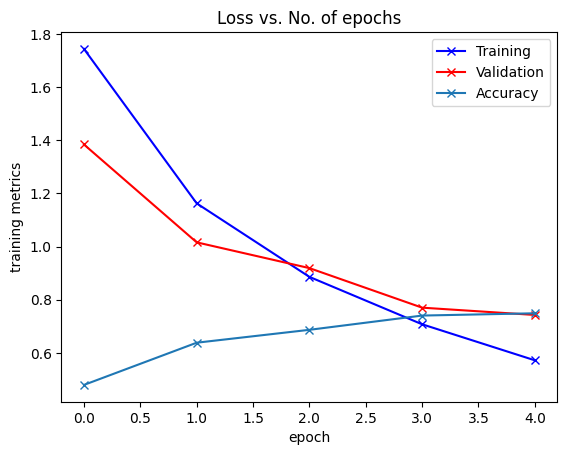

In [41]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


def plot_metrics(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    accuracies = [x['val_acc'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('training metrics')
    plt.legend(['Training', 'Validation','Accuracy'])
    plt.title('Loss vs. No. of epochs');

plot_metrics(history)


In [11]:
# Define a function to calculate entropy for each prediction
def evaluate_model(model, dataloader):
    model.eval()
    entropies = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

    return inputs,labels,outputs,probs

In [12]:
# Call the function to calculate entropies for each prediction
inputs,labels,outputs,probs = evaluate_model(model, testloader)
predicted = torch.max(outputs, 1)


In [13]:
predicted

torch.return_types.max(
values=tensor([ 5.4748,  1.5131,  5.8238,  3.5817, 12.6695,  6.1279,  3.8121,  6.7762,
         5.3907,  6.7046,  2.8479,  2.5041,  2.8239,  8.7816,  1.0366, 14.6479],
       device='cuda:0'),
indices=tensor([7, 3, 8, 0, 8, 4, 7, 0, 3, 5, 3, 0, 3, 5, 1, 7], device='cuda:0'))

In [14]:
labels

tensor([7, 5, 8, 0, 8, 2, 7, 0, 3, 5, 3, 8, 3, 5, 1, 7])

le predizioni indice 1,5, sono errate

In [15]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [16]:
def display_img(dataset,img,label,predicted_label):
    print(f"True Label : {dataset.classes[label]}")
    print(f"Predicted Label : {dataset.classes[predicted_label]}")
    cpu_img= img.cpu()
    plt.imshow(cpu_img.permute(1,2,0))



True Label : bird
Predicted Label : deer


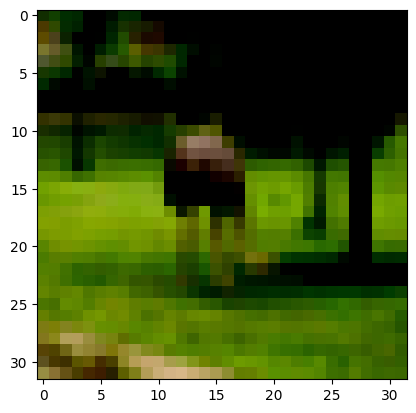

In [17]:
#display image in the dataset
display_img(trainset,inputs[5],labels[5],predicted[1][5])

True Label : dog
Predicted Label : cat


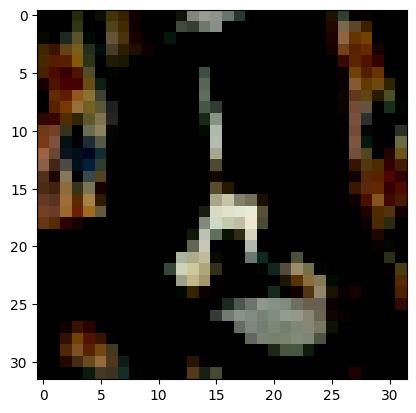

In [42]:
display_img(trainset,inputs[1],labels[1],predicted[1][1])

True Label : dog
Predicted Label : airplane


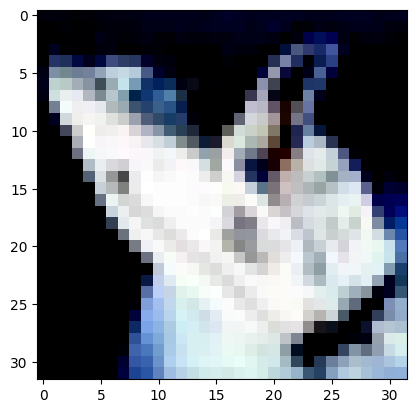

In [19]:
display_img(trainset,inputs[11],labels[1],predicted[1][11])

In [20]:
probs[5]

tensor([1.5762e-04, 3.9288e-07, 6.8684e-03, 1.4908e-03, 9.8294e-01, 2.5957e-03,
        2.5673e-04, 5.6811e-03, 1.5046e-06, 3.2614e-06], device='cuda:0')

In [43]:
probs[1]

tensor([0.0036, 0.1107, 0.0051, 0.3451, 0.0009, 0.1234, 0.0096, 0.0037, 0.2886,
        0.1094], device='cuda:0')

In [44]:
probs[11]

tensor([5.0947e-01, 1.3706e-05, 1.4639e-02, 2.6451e-01, 6.3813e-03, 1.6665e-01,
        9.1571e-04, 2.1114e-03, 3.5081e-02, 2.2920e-04], device='cuda:0')

In [23]:
def entropy(probabilities):
    # Ensure that the probabilities sum to 1.0
    if sum(probabilities)-1.0 > 0.001:
        raise ValueError("Probabilities must sum to 1.0")

    # Initialize the entropy value
    entropy_value = 0

    # Calculate the entropy using the formula
    for p in probabilities:
        if p > 0:
            entropy_value -= p * math.log2(p)

    return entropy_value

In [24]:
import math
entropy(probs[5])

tensor(0.1576, device='cuda:0')

In [25]:
entropy(probs[0])

tensor(0.3795, device='cuda:0')

In [26]:
probs[1]

tensor([0.0036, 0.1107, 0.0051, 0.3451, 0.0009, 0.1234, 0.0096, 0.0037, 0.2886,
        0.1094], device='cuda:0')

In [27]:
entropy(probs[1])

tensor(2.2914, device='cuda:0')

In [28]:
entropy([0.2,0.2,0.2,0.2,0.2])

2.321928094887362

In [29]:
entropy([0.5,0.5])

1.0

In [30]:
def create_uniform_distribution(n):
    if n <= 0:
        return []  # Return an empty list if n is not positive

    value = 1 / n
    result_list = [value] * n
    return result_list




In [31]:
# Example usage
n = 5
result = create_uniform_distribution(n)
print(result)  # Output: [0.2, 0.2, 0.2, 0.2, 0.2]

[0.2, 0.2, 0.2, 0.2, 0.2]


il valore massimo che può assumere l'entropia di classificazione varia in base al numero delle classi

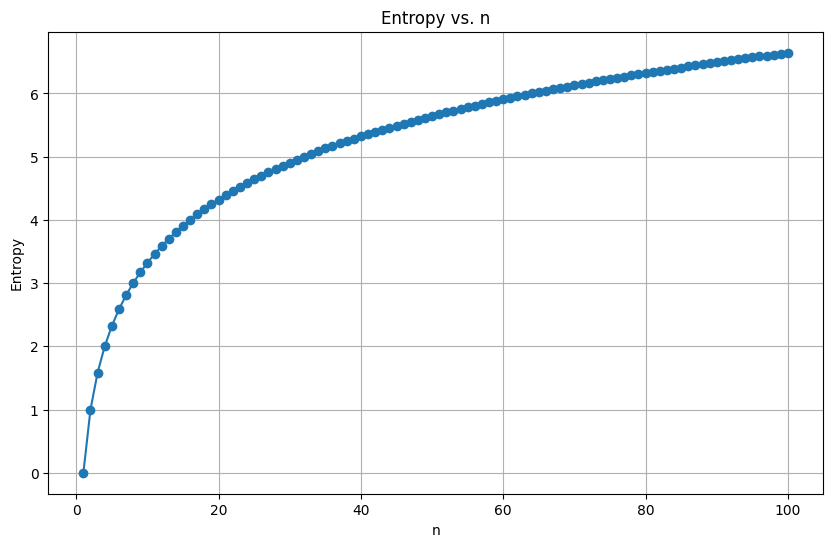

In [32]:
# Calculate entropy for values of n from 1 to 100
entropy_values = []
n_values=list(range(1, 101))
for n in n_values:
  n_value_dist= create_uniform_distribution(n)
  entropy_values.append(entropy(n_value_dist))

# Plot the entropy vs. n
plt.figure(figsize=(10, 6))
plt.plot(n_values, entropy_values, marker='o', linestyle='-')
plt.title('Entropy vs. n')
plt.xlabel('n')
plt.ylabel('Entropy')
plt.grid()
plt.show()

In [33]:
#maximum entropy value for 10 classes

max_entropy=entropy(create_uniform_distribution(len(trainset.classes)))

In [34]:
max_entropy

3.321928094887362

Definisco una metrica "normalizzata" rispetto al valore massimo possibile per il numeor di classi previste dal classificatore in modo da avere valori conforntabili tra classificatori diversi

classification_entropy= entropy(probs[idx])/max_entropy

Ora vado a calcolare la classification entropy per questo esempio con CIFAR10

In [35]:
for idx in range(0, len(probs)):
  classification_entropy= entropy(probs[idx])/max_entropy
  print("classification_entropy ",classification_entropy," output ", idx)

classification_entropy  tensor(0.1142, device='cuda:0')  output  0
classification_entropy  tensor(0.6898, device='cuda:0')  output  1
classification_entropy  tensor(0.0223, device='cuda:0')  output  2
classification_entropy  tensor(0.3536, device='cuda:0')  output  3
classification_entropy  tensor(1.6353e-05, device='cuda:0')  output  4
classification_entropy  tensor(0.0474, device='cuda:0')  output  5
classification_entropy  tensor(0.2544, device='cuda:0')  output  6
classification_entropy  tensor(0.2907, device='cuda:0')  output  7
classification_entropy  tensor(0.1145, device='cuda:0')  output  8
classification_entropy  tensor(0.1250, device='cuda:0')  output  9
classification_entropy  tensor(0.4078, device='cuda:0')  output  10
classification_entropy  tensor(0.5329, device='cuda:0')  output  11
classification_entropy  tensor(0.5447, device='cuda:0')  output  12
classification_entropy  tensor(0.0048, device='cuda:0')  output  13
classification_entropy  tensor(0.6399, device='cuda:0'

le predizioni 1, 5,11  sono errate. Ipotizzando di segliere come soglia di allerta classification_entropy = 0.5 posso costruire un rilevatore di previsioni ad alta incertezza. ottengo: 1 FP (output 14) , 2 TP (output 11 ,1), 1 FN (output 5), 12 TN (tutti gli altri)

\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}

In [45]:
14/16

0.875

$$ \text{Precision} = \frac{TP}{TP+FP}

In [37]:
2/(2+1)

0.6666666666666666

\text{Recall} = \frac{TP}{TP+FN}

In [46]:
2/(2+1)

0.6666666666666666